In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile 
zip_ref=zipfile.ZipFile("/content/drive/My Drive/carvana.zip",'r')
zip_ref.extractall('/data')
zip_ref.close()

<table>
    <tr>
        <td>
            <h1>Segmentation d'image: Carvana Image Masking Challenge</h1>
        </td>
    </tr>
</table>


<center><i>Réalisé par : </i>Douba JAFUNO </center>

<table>
    <tr style="text-align: center;vertical-align:middle">
    <td style="border-top: 1px solid black; border-bottom: 1px solid black;vertical-align: middle">     
 <h1>Plan du rapport</h1>
    </td>
   </tr>
</table>
 
<table style="width: 100%">
<tr>
    <td style="width: 15%">
    </td>
    <td style="width: 70%; text-align:left">
        <a href="#1"><h1>I. Introduction</h1></a><br>
           &emsp; <a href="#presentation">I.1 Présentation du problème</a><br>
           &emsp; <a href="#preparation">I.2 Préparation et Visualisation des données</a><br><br>

<a href="#2"><h1>II. Choix du Modèle et Apprentissage</h1></a><br><br>
    &emsp; <a href="#ini">II.1 Initialisation de l'architecture U-Net</a><br>
    &emsp; <a href="#rfp">II.2 Régler la fonction de perte avec le coefficient de similarité de dice</a><br>
    &emsp; <a href="#dpa">II.3 Démarrer le processus d'apprentissage</a><br>
    

<a href="#3"><h1>III. Prédire le modèle</h1></a><br><br>
&emsp; <a href="#vre">III.1 Visualiser le résultat sur un échantillon</h1></a><br><br>
      
<a href="#4"><h1>IV. Conclusion </h1></a><br><br>
     &nbsp; <a href="#ref">IV.1 Références</a><br>
    </td>
    <td style="width: 0%">
    </td>
</tr>
</table>



# <a name="1">I. Introduction</a>

## <a name="presentation"> Présentation du problème </a>

Cette étude se base sur un jeu de donné de Kaggle disponible [ici](https://www.kaggle.com/c/carvana-image-masking-challenge)

Comme pour tout achat important, une information complète et la transparence sont essentielles. Alors que presque tout le monde décrit l'achat d'une voiture d'occasion comme frustrant, il est tout aussi ennuyeux d'en vendre une, en particulier en ligne. Les acheteurs veulent tout savoir sur la voiture, mais ils doivent s'appuyer sur des images souvent floues et peu d'informations, ce qui fait de la vente de voitures d'occasion une industrie locale largement inefficace.

Carvana , une start-up de voitures d'occasion en ligne à succès, a vu l'opportunité d'établir une confiance à long terme avec les consommateurs et de rationaliser le processus d'achat en ligne.

Une partie intéressante de leur innovation est un studio photo rotatif personnalisé qui capture et traite automatiquement 16 images standard de chaque véhicule de leur inventaire. Alors que Carvana prend des photos de haute qualité, des reflets lumineux et des voitures avec des couleurs similaires à celles de l'arrière-plan provoquent des erreurs d'automatisation, ce qui nécessite un éditeur de photos qualifié pour changer.

![](https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/carvana_graphics.png)

Notre but sera de développer un algorithme qui supprime automatiquement l'arrière-plan du studio photo. Cela permettra à Carvana de superposer des voitures sur une variété de milieux. Nous analyserons un ensemble de données de photos, couvrant différents véhicules avec une grande variété de combinaisons d'année, de marque et de modèle.

In [3]:
%matplotlib inline
import cv2
import imageio
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.models import Model

print(cv2.__version__)
print(imageio.__version__)
print(tf.__version__)

4.1.2
2.4.1
2.4.1


## <a name="preparation"> Préparation et Visualisation des données </a>

Tout d'abord cet ensemble de données contient un grand nombre d'images de voitures (sous forme de fichiers .jpg). Chaque voiture a exactement 16 images, chacune prise sous des angles différents. Chaque voiture a un identifiant unique et les images sont nommées selon id_01.jpg, id_02.jpg ... id_16.jpg. En plus des images, nous recevons également des métadonnées de base sur la marque, le modèle, l'année et la finition de la voiture.

Pour l'ensemble de formation, nous avons un fichier .gif contenant le masque de découpe manuelle pour chaque image. La tâche de cette compétition consiste à **segmenter automatiquement les voitures** dans les images du dossier des ensembles de test. Pour dissuader l'étiquetage manuel, le test avec des images de voiture qui sont ignorées dans la notation a été complété.

La métrique utilisée pour noter ce concours nécessite que vos soumissions soient au format codé par durée. Veuillez consulter la page d'évaluation pour plus de détails et train_masks.csv pour un exemple réel de ce à quoi ressemble l'encodage.

Descriptions de fichiers
- / train / - ce dossier contient les images de l'ensemble d'entraînement
- / test / - ce dossier contient les images de l'ensemble de test. Nous devons prédire le masque (l'image segmenté au format encodé en longueur d'exécution) pour chacune des images de ce dossier
- / train_masks / - ce dossier contient les masques des ensembles d'entraînement au format .gif
- train_masks.csv - pour plus de commodité, ce fichier donne une version encodée en longueur des masques de l'ensemble d'entraînement.
- sample_submission.csv - affiche le format de soumission correct
- metadata.csv - contient des informations de base sur toutes les voitures de l'ensemble de données. Notez que certaines valeurs sont manquantes.

Chargeons seulement nos donnée **train** et **train masks** grâce aux fonctions load_image et binarise qui utilise [cv2.threshold](https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html) afin d'afficher le masque de segmentation, on utilisera ici le U-Net dans une tache d'apprentissage supervisée l'image train correspondant à l'entrée X et l'image train mask à sa cible que l'on souhaite retrouver.

In [4]:
from glob import glob

IMG_HEIGHT = 320
IMG_WIDTH = 480

train_img_paths = sorted(glob('/data/carvana/train/*.jpg'))
train_mask_paths = sorted(glob('/data/carvana/train_masks/*.gif'))

def load_image(path):
    # utiliser imageio comme cv2 
   # ne supporte pas le chargement d'un .gif
    img = imageio.imread(path)
    return cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

def binarise(img):
    thr, result = cv2.threshold(img, -1, 1, cv2.THRESH_OTSU)
    return result

train_imgs = np.array(
    [load_image(path) for path in train_img_paths])

train_masks = np.array(
    [binarise(load_image(path)) for path in train_mask_paths])

Visualisons une image et son masque de segmentation.

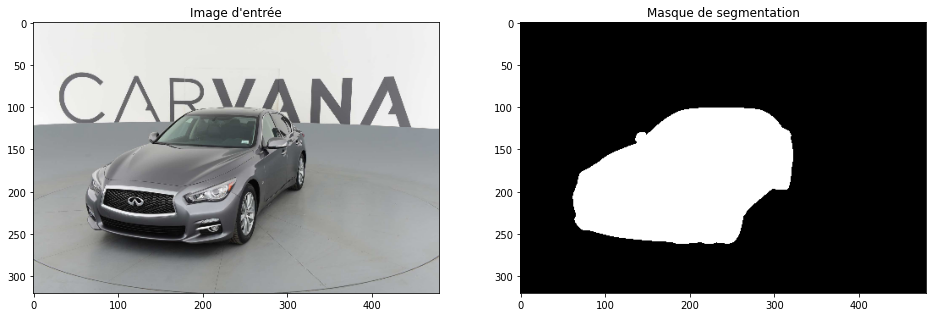

In [5]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.title("Image d'entrée")
plt.imshow(train_imgs[1]);

plt.subplot(1, 2, 2)
plt.title('Masque de segmentation')
plt.imshow(train_masks[1], cmap='gray');

# <a name="2">II. Choix du Modèle et Apprentissage</a>


## <a name="ini"> Initialisation de l'architecture U-Net </a>

Dans plusieurs domaine dont celui de l'imagerie médicale, la segmentation des images est une tâche cruciale, qui permet d’isoler dans l’image les objets significatifs sur lesquels doit porter l’analyse. Elle fournit donc au praticien une aide à la décision pour effectuer son diagnostic. La pertinence de cet outil repose principalement sur la qualité de segmentation. Un réseau concolutionnel prénommé [U-Net](https://arxiv.org/abs/1505.04597) développé pour la segmentation d'images biomédicales au département d'informatique de l'université de Fribourg en Allemagne c'est avéré très utile dans la segmentation d'image, voici son architecture: 

![](https://miro.medium.com/max/850/1*TXfEPqTbFBPCbXYh2bstlA.png)

Voici l'architecture du U-Net comme nous pouvons le voir ci-dessus celà ressemble à un U.

- **Unet Down (partie contractante)**: Au début l'image en entrée suivra les flèches bleu et rouge de façon à ce qu'elle soit redimensionnée à une taille plus petite
- **Unet Up (voie expansive)**: Une fois arrivé tout en bas du U l'image sera ensuite agrandi au fur et à mesure du chemin de droite avec les flèches bleu et verte.



**Implémentons étape par étape l'architecture du U-Net en nous bassant sur l'image ci-dessus.**

- 1)  Au départ notons que chaque processus constitue deux couches convolutionnelles, et le nombre de canaux change de 1 → 64, car le processus de convolution augmente la profondeur de l'image. La flèche rouge pointant vers le bas est le processus de regroupement maximum qui réduit de moitié la taille de l'image (la taille réduite de 572x572 → 568x568 est due à des problèmes de rembourrage, mais la mise en œuvre ici utilise:  padding='same' traduit par le rembourrage = "même").

![](https://miro.medium.com/max/265/1*xW5JGavuJAxwMsJRZs_0Rg.png)

In [6]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, 3))
s = Lambda(lambda x: x ) (inputs)  # lambda fonction de tensorflow pour ajouter des couches au modèle 
c1 = Conv2D(64, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(64, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

- 2) 
Le processus est répété 3 fois de plus :

![](https://miro.medium.com/max/480/1*yGu1oXPeqEvbKRuWL0z3Dw.png)

In [7]:
c2 = Conv2D(128, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(128, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(256, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(256, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(512, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(512, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

- 3) Deux couches convolutives sont encore construites, mais sans mise en commun maximale. L'image a été redimensionnée à ce moment en 28x28x1024. Passons maintenant à l'expansion.

![](https://miro.medium.com/max/390/1*0973DDf8V7UrgqzuLBiyaQ.png)



In [8]:
c5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (c5)

- 4) Dans le cheminement expansif, l'image va être agrandie à sa taille originale. La convolution transposée est une technique de suréchantillonnage qui permet d'augmenter la taille des images. Il y a une démo visualisée ici et une explication ici. Fondamentalement, il s'agit d'une opération de remplissage de l'image originale suivie d'une opération de convolution. La formule suivante est utilisée :

![](https://miro.medium.com/max/713/1*-2FyAsc71aCXiEHTkVnI7Q.png)



In [9]:
u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])

c6 = Conv2D(512, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(512, (3, 3), activation='relu', padding='same') (c6)

Après la convolution transposée, l'image est agrandie de 28x28x1024 → 56x56x512, puis cette image est concaténée avec l'image correspondante du chemin de contraction et forme ensemble une image de taille 56x56x1024. La raison est ici de combiner les informations des couches précédentes afin d'obtenir une prédiction plus précise.

- 5) Dans les deux lignes c7, 2 autres couches de convolution sont ajoutées.
Comme précédemment, ce processus est répété 3 fois de plus.

In [10]:
u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(256, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(256, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(128, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(128, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(64, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(64, (3, 3), activation='relu', padding='same') (c9)

- 6) Maintenant que nous avons atteint le sommet de l'architecture, la dernière étape consiste à remodeler l'image pour satisfaire nos exigences de prédiction.

![](https://miro.medium.com/max/765/1*yNbPtz4rIGgI6iE-1OPOdg.png)


- 7) La dernière couche est une couche de convolution avec 1 filtre de taille 1x1 (notons qu'il n'y a pas de couche dense dans l'ensemble du réseau) on retrouve une fonction d'activation [**sigmoïde**](https://fr.wikipedia.org/wiki/Sigmo%C3%AFde_(math%C3%A9matiques)) pour classer nos "pixels" (noires ou blanc?)  et le reste est identique pour la formation des réseaux de neurones.

In [11]:
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

In [12]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
import tensorflow

with tensorflow.device("/gpu:0"):
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, 3))
  
  conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
  conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

  conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
  conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

  conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
  conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

  conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
  conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

  conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
  conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

  up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
  conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
  conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

  up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
  conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
  conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

  up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
  conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
  conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

  up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
  conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
  conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

  conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

  model = tf.keras.Model(inputs=[inputs], outputs=[conv10])

  model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 320, 480, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 320, 480, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 320, 480, 64) 36928       conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 160, 240, 64) 0           conv2d_20[0][0]                  
______________________________________________________________________________________________

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 320, 480, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 320, 480, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 320, 480, 64) 36928       conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 160, 240, 64) 0           conv2d_20[0][0]                  
______________________________________________________________________________________________

## <a name="rfp"> Régler la fonction de perte avec le coefficient de similarité de dice</a>

Outre l'architecture du U-Net, l'un des éléments les plus importants de toute méthode d'apprentissage profond est le choix de notre fonction de perte.

Un choix naturel que nous connaissons peut-être est la fonction de perte d'entropie croisée.

Cependant, cette fonction de perte n'est pas idéale pour les tâches de segmentation en raison du déséquilibre important entre les classes (il n'y a généralement pas beaucoup de régions positives).
Une perte beaucoup plus courante pour les tâches de segmentation est le coefficient de similarité de Dice, qui est une mesure de la façon dont deux contours se chevauchent.

L'indice de Dice varie de 0 (non-concordance complète) à 1 (correspondance parfaite).
En général, pour deux ensembles $A$ et $B$, le coefficient de similarité de Dice est défini comme suit:$$\text{DSC}(A, B) = \frac{2 \times |A \cap B|}{|A| + |B|}.$$.

Ici, nous pouvons interpréter $A$ et $B$ comme des ensembles de **voxel** (pixel en 3d pour nos voitures), $A$ étant la région de la voiture prédite et $B$ étant la région de vérité de base (mask).

Notre modèle va attribuer à chaque voxel la valeur 0 ou 1.

- 0 signifie qu'il s'agit d'un voxel de fond
- 1 signifie qu'il fait partie de la région segmentée.

Dans le coefficient de dice , les variables de la formule sont

- $x$ : l'image d'entrée
- $f(x)$ : la sortie du modèle (prédiction)
- $y$ : l'étiquette (vérité de base réelle)

Le coefficient de dice "DSC" est :

$$\text{DSC}(f, x, y) = \frac{\sum_{i, j} f(x)_{ij} \times y_{ij} + \epsilon}{\sum_{i,j} f(x)_{ij} + \sum_{i, j} y_{ij} + \epsilon}$$
$\epsilon$ est un petit nombre (Smooth) qui est ajouté pour éviter la division par zéro

<img src="https://www.researchgate.net/publication/328671987/figure/fig4/AS:688210103529478@1541093483784/Calculation-of-the-Dice-similarity-coefficient-The-deformed-contour-of-the-liver-from.ppm" style="width:300px;height:200;">

Implémentons $DSC(f,x,y)$  nous pouvons utilisier tf.reduce_sum pour calculer les sommes .

Ici, nous utiliserons une fonction de perte **bce_dice_loss** spécialisée qui combine l'entropie croisée binaire et notre perte aux dés. Cette fonction est basée sur le fait que [les personnes qui ont participé à cette compétition ont obtenu de meilleurs résultats empiriques](https://www.kaggle.com/c/carvana-image-masking-challenge/discussion/40199). 

In [14]:
SMOOTH = 1.

def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + SMOOTH) / (tf.reduce_sum(y_true_f + y_pred_f) + SMOOTH)

def bce_dice_loss(y_true, y_pred):
    return 0.2 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

## <a name="dpa"> Démarrer le processus d'apprentissage </a>

On choisira Adam comme optimizeur avec un batch size de 4 et 70 epochs

In [15]:
with tensorflow.device("/gpu:0"):
  model.compile(tf.keras.optimizers.Adam(lr=1e-4),
              bce_dice_loss,
              metrics=[tf.keras.losses.binary_crossentropy, dice_coef])

In [16]:
Model = model.fit(train_imgs, train_masks.astype(np.float32), batch_size=4, epochs=70)

Epoch 1/70
8/8 [==============================] - 16s 464ms/step - loss: 0.0013 - binary_crossentropy: 1.2530 - dice_coef: 0.2493
Epoch 2/70
8/8 [==============================] - 4s 465ms/step - loss: -0.4320 - binary_crossentropy: 0.6598 - dice_coef: 0.5639
Epoch 3/70
8/8 [==============================] - 4s 465ms/step - loss: -0.4382 - binary_crossentropy: 0.6929 - dice_coef: 0.5768
Epoch 4/70
8/8 [==============================] - 4s 466ms/step - loss: -0.4819 - binary_crossentropy: 0.5731 - dice_coef: 0.5966
Epoch 5/70
8/8 [==============================] - 4s 467ms/step - loss: -0.5666 - binary_crossentropy: 0.5828 - dice_coef: 0.6832
Epoch 6/70
8/8 [==============================] - 4s 470ms/step - loss: -0.5898 - binary_crossentropy: 0.5798 - dice_coef: 0.7058
Epoch 7/70
8/8 [==============================] - 4s 470ms/step - loss: -0.7190 - binary_crossentropy: 0.2856 - dice_coef: 0.7762
Epoch 8/70
8/8 [==============================] - 4s 472ms/step - loss: -0.7743 - binary_c

On peut observer l'évolution du coefficient de Dice (qui se rapproche de 1) et de la perte (qui devrais décroître).

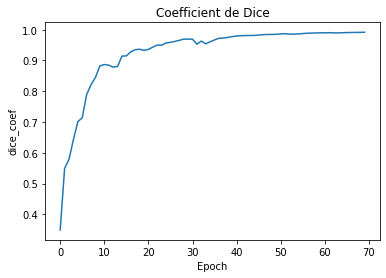

In [17]:
plt.plot(Model.history['dice_coef'])
plt.title('Coefficient de Dice')
plt.ylabel('dice_coef')
plt.xlabel('Epoch')
plt.show()

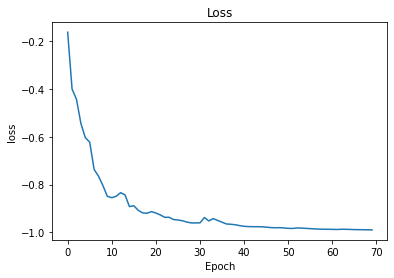

In [18]:
plt.plot(Model.history['loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()

# <a name="3">III. Prédire le modèle</a>

On fais des prédictions avec les données tests.

In [19]:
test_paths = sorted(glob('/data/carvana/test/*.jpg'))

def test_img_generator(test_paths):
    for path in test_paths:
        yield np.array([load_image(path)])

In [20]:
pred = model.predict(test_img_generator(test_paths))
pred = np.squeeze(pred)  #Enleve les axes de longueur un de pred

## <a name="vre">Visualiser le résultat sur un échantillon</a>

Visualisons le résultat sur 4 images test.

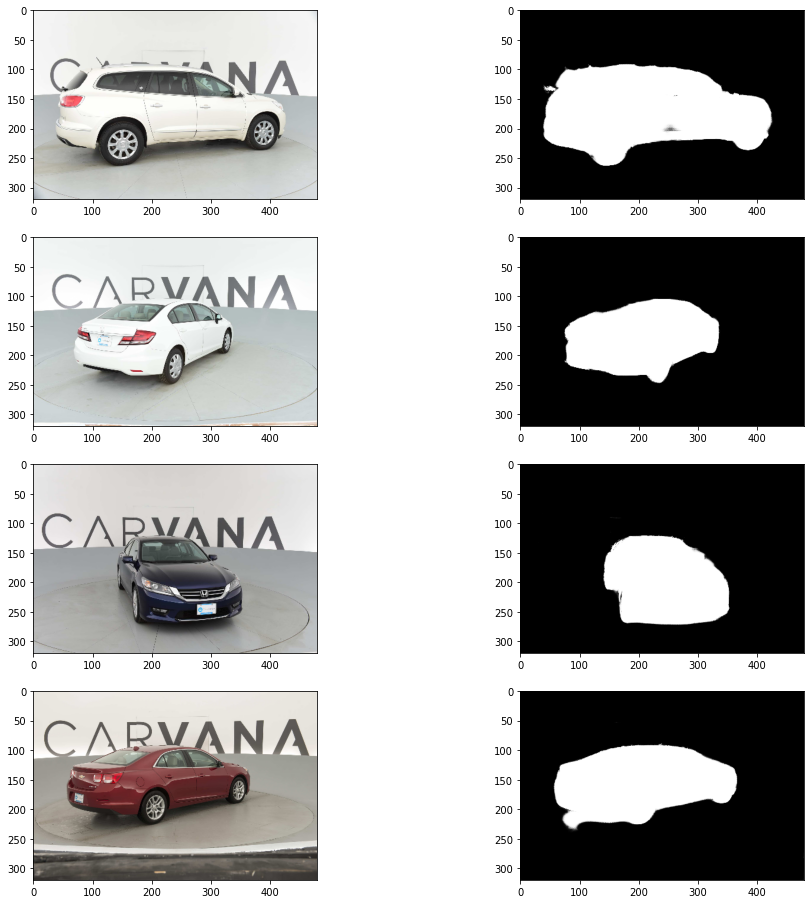

In [21]:
SHOW_SAMPLES = 4
SAMPLES_OFFSET = 4

fig = plt.figure(0, figsize=(16, 16))

for i in range(SHOW_SAMPLES):
    plt.subplot(SHOW_SAMPLES, 2, 2*i+1)
    plt.imshow(load_image(test_paths[SAMPLES_OFFSET+i]))
    plt.subplot(SHOW_SAMPLES, 2, 2*i+2)
    plt.imshow(pred[SAMPLES_OFFSET+i], cmap='gray')

# <a name="4">IV. Conclusion </a>

Tout au long de ce projet nous avons pu découvrir le U-Net qui est très utile en imagerie médicale notamment avec son utilité pour la segmentation d'image, nous avons aussi vu le coefficient de **Dice** et nous avons un peu près réussi à segmenter nos images de Carvana.

## <a name="ref">Références</a>

- [Towardsdatascience: UNet — Line by Line Explanation](https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5)

- [Understanding the dice coefficient](https://forums.fast.ai/t/understanding-the-dice-coefficient/5838)

- [Kaggle U-Net-BN-Aug-Strat-Focal_Loss](https://www.kaggle.com/alexanderliao/u-net-bn-aug-strat-focal-loss-fixed/notebook)


- [Performances dans la segmentation d'images medicales](https://www.researchgate.net/publication/332566924_Performances_dans_la_segmentation_d'images_medicales)

- [Image Dice](https://www.researchgate.net/figure/Calculation-of-the-Dice-similarity-coefficient-The-deformed-contour-of-the-liver-from_fig4_328671987)